# Two-stage solution

In [1]:
import torch
import torchvision

In [2]:
torch.cuda.empty_cache()
#device = "cpu"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda:0
Devices count: 1


In [3]:
import pandas
import numpy
import pickle

In [4]:
from pathlib import Path

In [5]:
from misc.data import SimpleClassifierDataset, SupplementaryDataset, concatenate_collate_fn, detection_results_to_annotations

In [6]:
from PytorchWildlife.models import detection as pw_detection
from PytorchWildlife.models import classification as pw_classification
from PytorchWildlife.data import transforms as pw_trans
from PytorchWildlife import utils as pw_utils

In [7]:
classifier_model_name = "swin_v2_s"
classifier_weights_name = "Swin_V2_S_Weights"
classifier_weights_subname = "IMAGENET1K_V1"

In [8]:
image_size = 232

## Data

In [9]:
data_path = Path("./data/train_data_minprirodi/")
images_path = data_path / "images"
annotation_path = data_path / "annotation.csv"

In [10]:
model_path = data_path / f"models/{classifier_weights_name}/{classifier_weights_subname}"

In [11]:
annotation = pandas.read_csv(annotation_path)
annotation

,Name,Bbox,Class
0,1001958.jpg,"0.7075520833333333,0.5319444444444444,0.282812...",1
1,1001958.jpg,"0.09505208333333333,0.6305555555555555,0.19010...",0
2,1001958.jpg,"0.031510416666666666,0.7434027777777777,0.0630...",0
3,1002155.jpg,"0.8135416666666667,0.6976851851851852,0.371875...",0
4,1002155.jpg,"0.3221354166666667,0.7939814814814815,0.477604...",0
...,...,...,...
1980,1997546.jpg,"0.34661458333333334,0.490625,0.6015625,0.48958...",1
1981,1997602.jpg,"0.7317708333333334,0.25601851851851853,0.30625...",0
1982,1999067.jpg,"0.5630208333333333,0.5020833333333333,0.519791...",1
1983,1999067.jpg,"0.9572916666666667,0.5881944444444445,0.085416...",0


In [12]:
dataset = SimpleClassifierDataset(
    images_path,
    annotation,
    torchvision.transforms.Resize((image_size, image_size), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
)

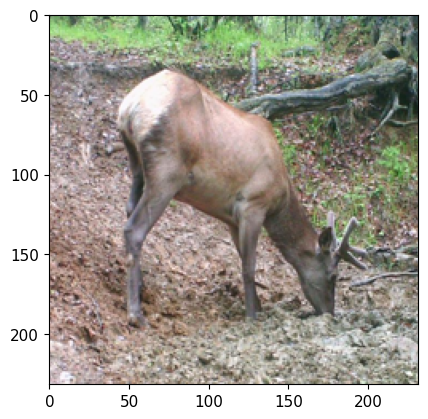

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(dataset[53][0].cpu().detach().numpy().swapaxes(0,2).swapaxes(1,0))
plt.show();

In [14]:
from sklearn.model_selection import train_test_split

unique_names = annotation["Name"].unique()
train_names, test_names = train_test_split(unique_names, test_size=0.2, random_state=42)

In [15]:
train_annotation = annotation #annotation[annotation["Name"].isin(train_names)].reset_index(drop=True)
test_annotation  = annotation[annotation["Name"].isin(test_names)].reset_index(drop=True)

In [16]:
train_dataset = SimpleClassifierDataset(images_path, train_annotation, dataset.transform)
test_dataset  = SimpleClassifierDataset(images_path, test_annotation, dataset.transform)

In [17]:
train_batch_size = 24
test_batch_size  = 128

In [18]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=test_batch_size,  shuffle=False)

### Negative datasets

In [19]:
empty_path = data_path / "images_empty"
all_path   = data_path / "images"

In [20]:
empty_dataset = SupplementaryDataset(
    empty_path,
    torchvision.transforms.Resize((image_size, image_size), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
)

all_dataset = SupplementaryDataset(
    all_path,
    torchvision.transforms.Resize((image_size, image_size), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
)

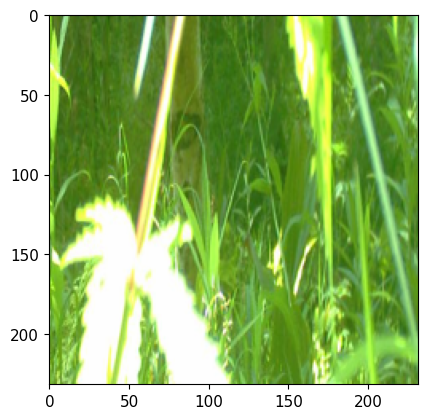

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(empty_dataset[53][0].cpu().detach().numpy().swapaxes(0,2).swapaxes(1,0))
plt.show();

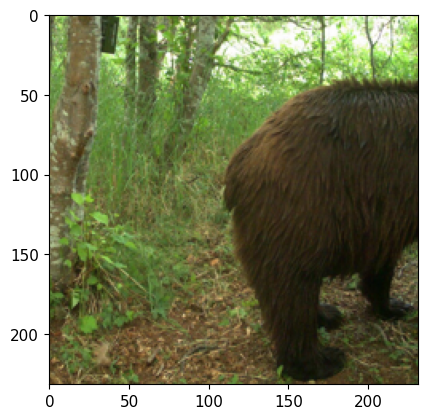

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(all_dataset[53][0].cpu().detach().numpy().swapaxes(0,2).swapaxes(1,0))
plt.show();

In [23]:
empty_dataloader = torch.utils.data.DataLoader(empty_dataset, batch_size=train_batch_size, shuffle=True)
all_dataloader   = torch.utils.data.DataLoader(all_dataset,   batch_size=train_batch_size, shuffle=True)

## Model

In [24]:
from misc.train import *

In [25]:
weights = getattr(getattr(torchvision.models, classifier_weights_name), classifier_weights_subname)

In [26]:
classifier = getattr(torchvision.models, classifier_model_name)(weights=weights).to(device)

In [27]:
model = Classifier(
    #detector,
    classifier.train(),
    ClassifierHead(1000),
    weights.transforms()
).to(device)

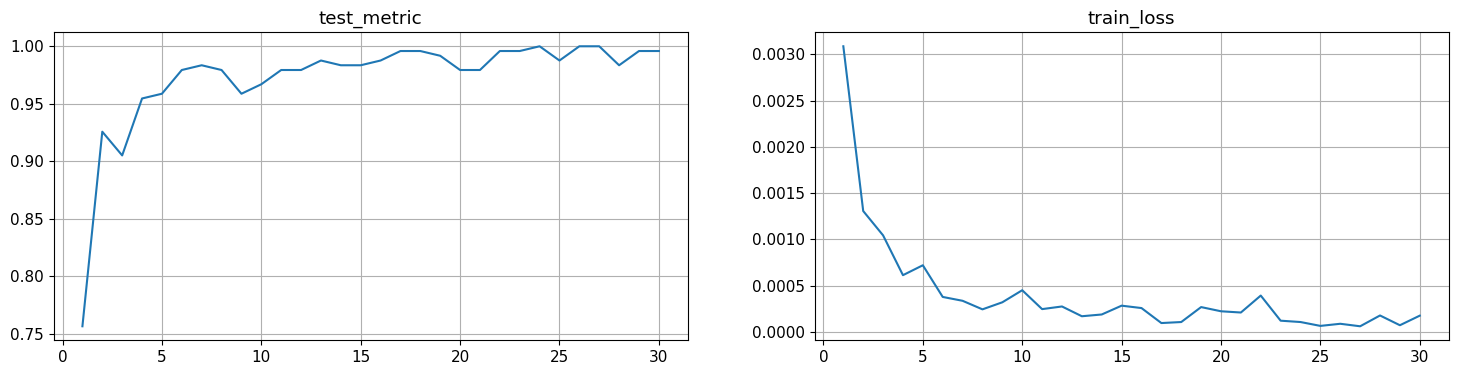

In [28]:
history = train_detector_classifier(
    model,
    train_dataloader,
    test_dataloader,
    torch.optim.Adam(model.parameters(), lr=5.0e-5),
    device,
    negative_dataloaders=[
        #empty_dataloader,
        all_dataloader,
    ],
    model_path=model_path,
    n_epochs=30
)

In [29]:
history

defaultdict(list,
            {'train_loss': [0.0030863340612887055,
              0.0013055815030275496,
              0.0010424522929523405,
              0.000612219870096733,
              0.0007193016426241621,
              0.0003769062554952056,
              0.0003352078933264724,
              0.00024273533630977593,
              0.00031905071842277003,
              0.0004494097485656593,
              0.0002453369510676621,
              0.0002738622833488613,
              0.00016821794841702213,
              0.00018722953041449173,
              0.00028253492225643065,
              0.0002567277306905054,
              9.469484299256822e-05,
              0.00010557546164638929,
              0.0002672906805595498,
              0.00022192218170850186,
              0.00020846733642117666,
              0.0003917300562327509,
              0.00012017803270125026,
              0.00010572645196305552,
              6.3874392944988e-05,
              8.680603079366714e-05,